In [1]:
import numpy as np
import pandas as pd
import sys
import pickle
sys.path.append("../../")
sys.path.append("../")
import spacy
from src.loader import TextLoader
from src.purifier import Purifier
from tqdm import tqdm
from pathlib import Path
import torch

from transformers import BertTokenizer
from torch import nn
from transformers import BertModel

c:\Users\Jurek\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def count_label(df, labels):
    label_count_dict = {}
    labeled_df_dict = {}
    for label in labels:
        label_df = df[df['discourse_type']==label]
        label_count_dict[label] = len(label_df)
        labeled_df_dict[label] = label_df
    return label_count_dict, labeled_df_dict

def oversampling(df, labels, amount_for_class = 1000):
    new_df = pd.DataFrame()
    label_count, labeled_df_dict = count_label(df, labels)
    print(label_count)
    for label, count in label_count.items():
        print(label)
        lb_df = labeled_df_dict[label]
        if count < amount_for_class:
            while len(lb_df) < amount_for_class:
                row = labeled_df_dict[label].sample()
                lb_df = pd.concat([lb_df, row])
                #lb_df.loc[len(new_df)] = [row.values[0][0], row.values[0][1]]
        new_df = pd.concat([new_df, lb_df])
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    return new_df

def undersampling(df, labels, amount_for_class = 1000):
    new_df = pd.DataFrame()
    label_count, labeled_df_dict = count_label(df, labels)
    for label, count in label_count.items():
        lb_df = pd.DataFrame()
        if count < amount_for_class:
            lb_df = labeled_df_dict[label]
            new_df = pd.concat([new_df, lb_df])
        else:
            while len(lb_df) < amount_for_class:
                row = labeled_df_dict[label].sample()
                lb_df = pd.concat([lb_df, row])
            new_df = pd.concat([new_df, lb_df])
    return new_df

In [4]:
module_path = Path.cwd().parent.parent
if module_path not in sys.path:
    sys.path.insert(0, str(module_path))

In [5]:
path = Path(module_path / "data" / "train_v1_no_predictionstring.xz")
data = pd.read_csv(path, compression="xz")
data = data[["discourse_text", "discourse_type"]]
data.head()

,discourse_text,discourse_type
0,Modern humans today are always on their phone....,Lead
1,They are some really bad consequences when stu...,Position
2,Some certain areas in the United States ban ph...,Evidence
3,When people have phones they know about certai...,Evidence
4,Driving is one of the way how to get around. P...,Claim


In [6]:
data["discourse_type"].unique()

array(['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement',
       'Counterclaim', 'Rebuttal'], dtype=object)

In [7]:
labels = {'Lead':0,
          'Position':1,
          'Evidence':2,
          'Claim':3,
          'Concluding Statement':4,
          'Counterclaim':5, 
          'Rebuttal':6
}

In [8]:
data = undersampling(data, ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement', 'Counterclaim', 'Rebuttal'], 15000)

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [10]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['discourse_type']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['discourse_text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [11]:
from sklearn.model_selection import train_test_split
np.random.seed(2137)
df_train, df_test = train_test_split(data, test_size=0.1)
df_val, df_test = train_test_split(df_test, test_size=0.25)

In [12]:
df_test

,discourse_text,discourse_type
132580,I think you should get edvice from multiple pe...,Position
10014,the advantages of limitating car usage is a go...,Concluding Statement
58618,In conclusion Those were some of my best argum...,Concluding Statement
72305,ok we could explain to him that a lot of us ar...,Claim
59523,Malins team captured a extraordinary photo usi...,Evidence
...,...,...
50696,i tink that this program fantastic,Position
45602,like in paragraph 2 he says venus is referred ...,Evidence
139736,As an example Generic Name is at the shoe stor...,Evidence
80106,In my conclution we should not have self drive...,Concluding Statement


In [12]:
#np.random.seed(2137)
#df_train, df_val, df_test = np.split(data.sample(frac=1, random_state=42), [int(.8*len(data)), int(.9*len(data))])

In [13]:
print(len(df_train),len(df_val), len(df_test))

70157 5847 1949


In [14]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.4):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout1 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 256)
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(256, 64)
        self.dropout3 = nn.Dropout(dropout)
        self.linear3 = nn.Linear(64, 7)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask, return_dict=False)
        dropout1_output = self.dropout1(pooled_output)
        linear1_output = self.linear1(dropout1_output)
        dropout2_output = self.dropout2(linear1_output)
        linear2_output = self.linear2(dropout2_output)
        dropout3_output = self.dropout3(linear2_output)
        linear3_output = self.linear3(dropout3_output)
        final_layer = self.relu(linear3_output)

        return final_layer

In [15]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)

    use_cuda = torch.cuda.is_available()
    print(use_cuda)
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    
    optimizer = Adam(model.parameters(), lr= learning_rate)
    

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [17]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-5
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


True


100%|██████████| 8770/8770 [34:23<00:00,  4.25it/s]


Epochs: 1 | Train Loss:  0.121                 | Train Accuracy:  0.686                 | Val Loss:  0.100                 | Val Accuracy:  0.742


100%|██████████| 8770/8770 [34:16<00:00,  4.26it/s]


Epochs: 2 | Train Loss:  0.072                 | Train Accuracy:  0.826                 | Val Loss:  0.092                 | Val Accuracy:  0.773


100%|██████████| 8770/8770 [31:40<00:00,  4.61it/s]


Epochs: 3 | Train Loss:  0.039                 | Train Accuracy:  0.912                 | Val Loss:  0.099                 | Val Accuracy:  0.789


100%|██████████| 8770/8770 [31:32<00:00,  4.63it/s]


Epochs: 4 | Train Loss:  0.022                 | Train Accuracy:  0.955                 | Val Loss:  0.116                 | Val Accuracy:  0.778


100%|██████████| 8770/8770 [31:31<00:00,  4.64it/s]


Epochs: 5 | Train Loss:  0.015                 | Train Accuracy:  0.970                 | Val Loss:  0.127                 | Val Accuracy:  0.780


In [18]:
wyniki = []
y_t = []

In [19]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              wyniki.append(output.argmax(dim=1))
              y_t.append(test_label)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.789


In [20]:
wyniki
y_pred = []
for t in wyniki:
    for b in t:
        y_pred.append(int(b))

In [21]:
y_t
y_true = []
for t in y_t:
    for b in t:
        y_true.append(int(b))

In [22]:
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

weighted 0.7872309272790239
micro 0.7891226269881991
macro 0.7652925338981608
matthews_corrcoef 0.7475102926484892


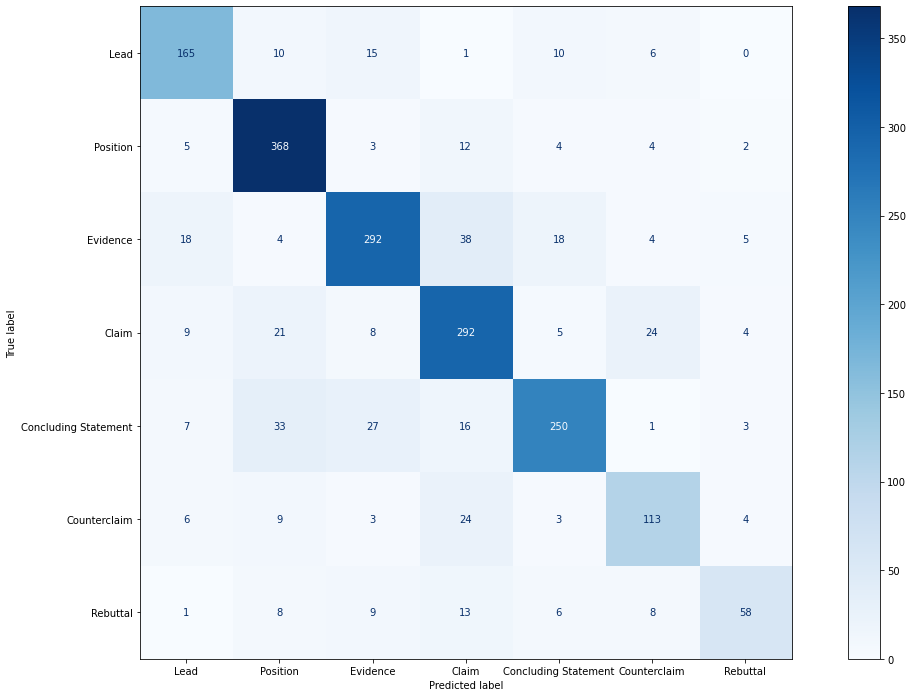

In [23]:
print('weighted', f1_score(y_true, y_pred, average='weighted'))
print('micro', f1_score(y_true, y_pred, average='micro'))
print('macro', f1_score(y_true, y_pred, average='macro'))
print('matthews_corrcoef', matthews_corrcoef(y_true, y_pred))

fig = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                               labels=[0,1,2,3,4,5,6], 
                                               display_labels = ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement','Counterclaim', 'Rebuttal'],
                                               cmap=plt.cm.Blues,
                                               )
fig = fig.ax_.get_figure() 
fig.set_figwidth(20)
fig.set_figheight(12)

In [ ]:
import time
torch.save(model, f"bert_classifier_model_cased_undersampling_1")

In [17]:
the_model = torch.load("bert_classifier_model_cased_2")

In [22]:
#import time
#torch.save(model.state_dict(), f"bert_classifier_state_dict_{time.time()}")